# Part 2. Digit Recognition

### Using Traditional ML Classifiers (i.e. No Deep Learning)

In [420]:
import math 
import numpy as np
import cv2 as cv
import time
from scipy import stats 
from matplotlib import pyplot as plt
import skfuzzy as fuzz
import csv
import os
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [410]:
class Region:
    def __init__(self):
        self.xm = 0
        self.ym = 0
        self.xx = 0
        self.yy = 0
        self.xy = 0
        self.xxx = 0
        self.yyy = 0
        self.xxy = 0
        self.xyy = 0
        self.Perimetro = 0
        self.Area = 0
        self.closed = False
        self.edgePoints = []
        self.red = 0
        self.green = 0
        self.blue = 0
    def addPoint(self,x,y,isedge,color):
        self.xm = self.xm + x
        self.ym = self.ym + y
        self.xx = self.xx + x*x
        self.yy = self.yy + y*y
        self.xy = self.xy + x*y
        self.xxx = self.xxx + x*x*x
        self.yyy = self.yyy + y*y*y
        self.xxy = self.xxy + x*x*y
        self.xyy = self.xyy + x*y*y
        self.Area = self.Area + 1
        self.red = self.red + color[0]
        self.green = self.green + color[1]
        self.blue = self.blue + color[2]

        if isedge > 0:
#            self.edgePoints.append((x+0.5,y+0.5))
            self.Perimetro = self.Perimetro + 1
            if (isedge & 1) > 0: #up
                self.edgePoints.append((x+0.5,y+0.001))
            if (isedge & 2) > 0: #left
                self.edgePoints.append((x+0.001,y+0.5))
            if (isedge & 4) > 0: #down
                self.edgePoints.append((x+0.5,y+0.999))
            if (isedge & 8) > 0: #right
                self.edgePoints.append((x+0.999,y+0.5))
    def addRegion(self,region):
        if (self.closed == False) and (region.closed == False) and (region.Area > 0):
            self.xm = self.xm + region.xm
            self.ym = self.ym + region.ym
            self.xx = self.xx + region.xx
            self.yy = self.yy + region.yy
            self.xy = self.xy + region.xy
            self.xxx = self.xxx + region.xxx
            self.yyy = self.yyy + region.yyy
            self.xxy = self.xxy + region.xxy
            self.xyy = self.xyy + region.xyy
            self.Area = self.Area + region.Area
            self.Perimetro = self.Perimetro + region.Perimetro
            self.red = self.red + region.red
            self.green = self.green + region.green
            self.blue = self.blue + region.blue
            for n in range(len(region.edgePoints)):
                self.edgePoints.append(region.edgePoints[n])
    def closeRegion(self):
        if (self.Area > 0) and (self.closed == False):
            self.xm = self.xm/self.Area
            self.ym = self.ym/self.Area
            self.xx = self.xx/self.Area - self.xm*self.xm
            self.yy = self.yy/self.Area - self.ym*self.ym
            self.xy = self.xy/self.Area - self.xm*self.ym
            self.red = self.red/self.Area
            self.green = self.green/self.Area
            self.blue = self.blue/self.Area
            self.closed = True
        

In [411]:
def smoothPointSet(points,steps):
    lpts = len(points)
    for stp in range(steps):
        apt = np.array(points)
        for n in range(lpts):
            bidx = (n + lpts - 1) % lpts
            uidx = (n + lpts + 1) % lpts
            points[n] = ((apt[bidx][0]+apt[n][0]+apt[uidx][0])/3,(apt[bidx][1]+apt[n][1]+apt[uidx][1])/3)
    return points
    

In [412]:
def getInvariantFeatures(points, displayIndividual = True):
    outline_points = points

    # Convert the list of points to integer coordinates
    points = np.array([(int(pt[0]), int(pt[1])) for pt in outline_points[0]])

    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    
    # Create a binary image that fits the bounding box
    binary_image = np.zeros((y_max - y_min + 1, x_max - x_min + 1), dtype=np.uint8)
    
    # Shift points to fit within the binary image bounds
    shifted_points = points - [x_min, y_min]
    
    # Draw the outline in the binary image
    for x, y in shifted_points:
        binary_image[y, x] = 1
    
    # Compute Hu Moments
    moments = cv.moments(binary_image)
    hu_moments = cv.HuMoments(moments).flatten()
    hu1, hu2, hu3, hu4, hu5, hu6, hu7 = hu_moments
    
    # Compute Euler's number
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_image, connectivity=8)
    euler_number = num_labels - 1  # Subtract background from component count
    
    if displayIndividual:
        print("Hu Moments:", hu_moments)
        print("Euler's Number:", euler_number)
        
        # Display the generated binary image
        plt.imshow(binary_image, cmap='gray')
        plt.title("Digit Sample from the Training Set")
        plt.show()

    return euler_number, hu1, hu2, hu3, hu4, hu5, hu6, hu7, x_min, y_min, x_max, y_max

In [413]:
def orderPointSet(opoints,EdgeImage):
    orderpointsList = []
    if len(opoints) > 0:
        points = opoints.copy()
        neigbors = np.array([(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(0,0)])*0.5
        plen = len(points)
        n = 0
        last = 0
        inserted = 0
        orderpoints = []
        orderpoints.append(points[0])
        points.pop(0)
        lastidx = 0
        who = 0
        for inserted in range(plen-1):
            n = 0
            cpt = np.array(orderpoints[last])
            edgetype = EdgeImage[int(cpt[1]),int(cpt[0])]
            dis = 1
            thepoints = np.array(points)                
            thesum = np.sum(abs(thepoints-cpt),axis=1)
            lastdir = np.sum(np.square(neigbors-neigbors[lastidx]),axis=1)
            dis = 10
            idx = lastidx;
            for n in range(len(points)):
                if thesum[n] <= 2:
                    npoints = cpt + neigbors
                    theNsum = np.sum(np.abs(npoints-thepoints[n]),axis=1) + 0.01*lastdir
                    for nn in range(8):
                        nedgetype = EdgeImage[int(npoints[nn,1]),int(npoints[nn,0])]
                        dist = theNsum[nn] + 0.001*((edgetype ^ nedgetype) > 0)
                        if dist < dis:
                            dis = dist
                            idx = nn
                            who = n
            if dis < 1.0:
                lastidx = idx
                orderpoints.append(points[who])
                points.pop(who)
            else:
                if len(orderpoints) > 2:
                    orderpointsList.append(orderpoints)
                orderpoints = []
                orderpoints.append(points[0])
                points.pop(0)
                last = 0
            last = len(orderpoints) - 1
        if len(orderpoints) > 2:
            orderpointsList.append(orderpoints)
    return orderpointsList    

In [414]:

def SegmentationRegions(image,colorimg): 
    regions = []
    si,sj = image.shape;
    fimage = image.astype(np.int16)
    EdgeImage = image.astype(np.int16)
        
    regionlabels = image[:,:];
    regionlabels = regionlabels.astype(np.int32)
    shortlabellut = np.zeros((int(si*sj/100+1),), dtype=np.int32)
    labellut = shortlabellut
    upKernel = np.array((
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    upsameI = abs(cv.filter2D(fimage,-1,upKernel)) == 0  
    leftKernel = np.array((
    [0, 0, 0],
    [-1, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    leftsameI = abs(cv.filter2D(fimage,-1,leftKernel)) == 0
    downKernel = np.array((
    [0, 0, 0],
    [0, 1, 0],
    [0, -1, 0]), dtype=np.int16)
    downsameI = abs(cv.filter2D(fimage,-1,downKernel)) == 0  
    rightKernel = np.array((
    [0, 0, 0],
    [0, 1, -1],
    [0, 0, 0]), dtype=np.int16)
    rightsameI = abs(cv.filter2D(fimage,-1,rightKernel)) == 0
    currentlabel=0
    uplabelArray = regionlabels[0,:]
    upsame = False
    leftsame = False
    thelabel = 0
    uplabel = 0
    leftlabel = 0
    regions.append(Region())
    for i in range(si):
        leftlabel = labellut[regionlabels[i,0]]
        for j in range(sj):
            color = colorimg[i,j,:]
            thelabel = leftlabel 
            upsame = False
            leftsame = False
            EdgeImage[i,j] = 1*(not upsameI[i,j]) +  2*(not leftsameI[i,j]) + 4*(not downsameI[i,j]) + 8*(not rightsameI[i,j])
            if i>0:
                uplabel = uplabelArray[j]
                upsame = upsameI[i,j]
                if upsame:
                    thelabel = uplabel
            if j>0:
                leftsame = leftsameI[i,j]
                if leftsame:
                    if thelabel > leftlabel:
                        thelabel = leftlabel                
                    if upsame:
                        thelabel = labellut[thelabel]
                        labellut[leftlabel] = thelabel
                        labellut[uplabel] = thelabel
            if (not(upsame) and  not(leftsame)):
                currentlabel = currentlabel + 1
                regions.append(Region())
                thelabel = currentlabel
                if (currentlabel >= labellut.size):
                    labellut = np.append(labellut, shortlabellut)
                labellut[currentlabel] = currentlabel
            else:
                thelabel = labellut[thelabel]
            regionlabels[i,j] = thelabel
            regions[thelabel].addPoint(j,i,EdgeImage[i,j],color)
            leftlabel = thelabel
        uplabelArray = regionlabels[i,:]
    print(len(regions))
    lreg = len(regions)
    changes = 1
    while changes > 0:
        changes = 0
        for idx in range(lreg):
            newlabel = labellut[idx]
            if regions[idx].Area > 0 and idx != newlabel:
                changes = changes + 1
                regions[newlabel].addRegion(regions[idx])
                regions[idx].__init__()
            labellut[idx] = labellut[newlabel]
        print(changes)
    closed = 0
    for n in range(lreg):
        if (n == labellut[n]) and (regions[n].Area > 0):
            closed = closed + 1
            regions[n].closeRegion()
    print(closed)
    regionlabels = labellut[regionlabels]
    return regionlabels, regions, EdgeImage


<hr />

## Dataset Creation

In this section, starting off from a set of 10 images (one for each digit) containing 50 samples each, we extract the contours of each digit and compute their Euler's number and Hu moments to create a dataset using those properties as the describing features of each digit sample, as they are invariant to transformations.

#########################################################################

EXTRACTION OF DIGIT 0

#########################################################################


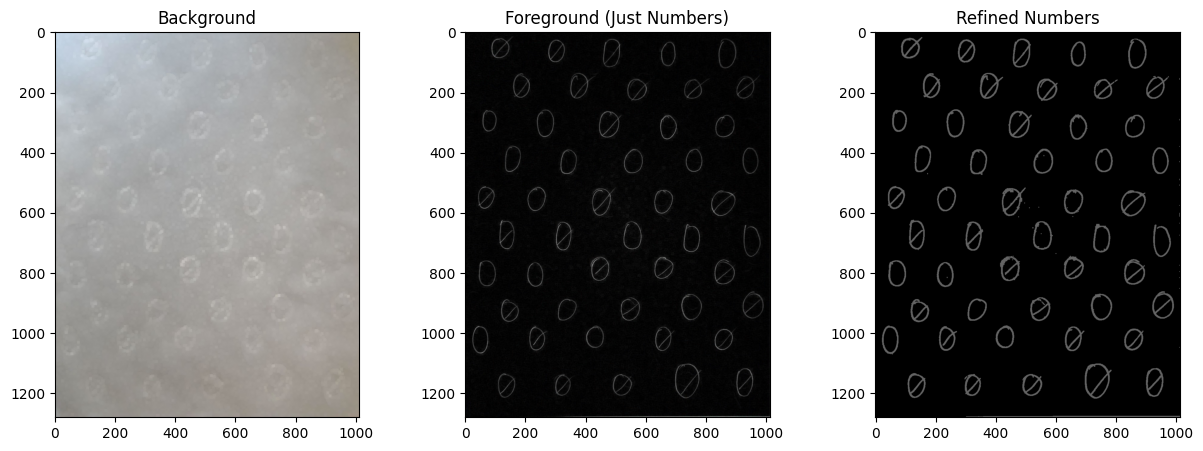

6061
5868
53
0
192


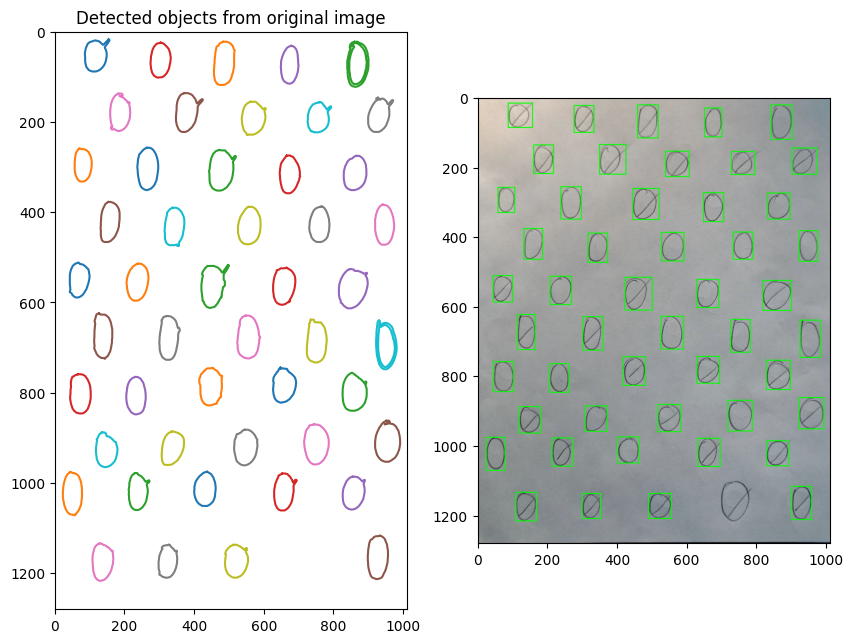

#########################################################################

EXTRACTION OF DIGIT 1

#########################################################################


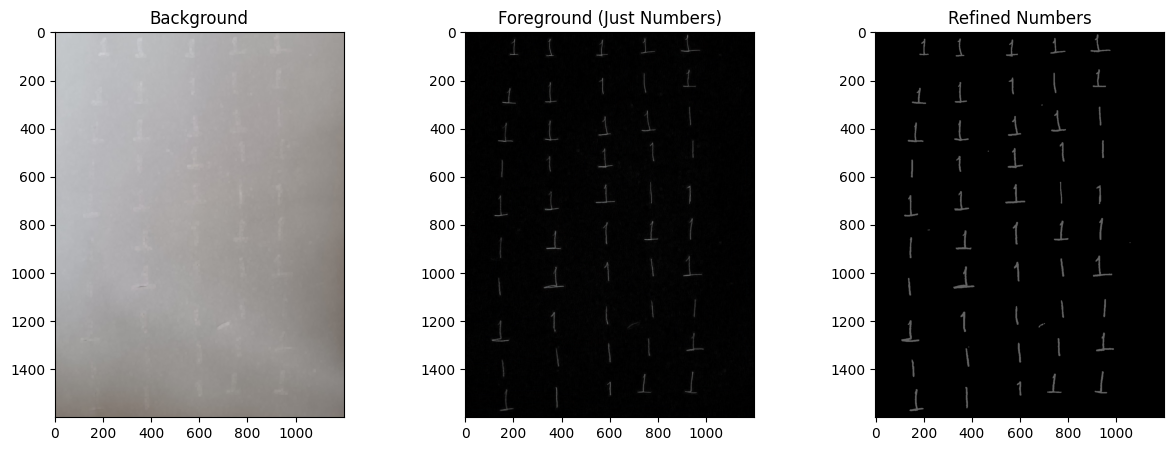

1008
944
39
0
63


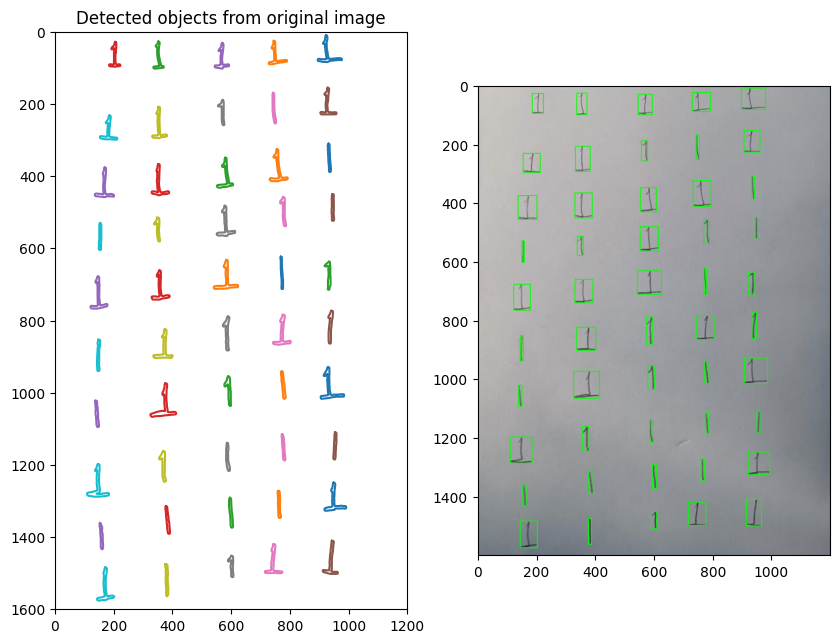

#########################################################################

EXTRACTION OF DIGIT 2

#########################################################################


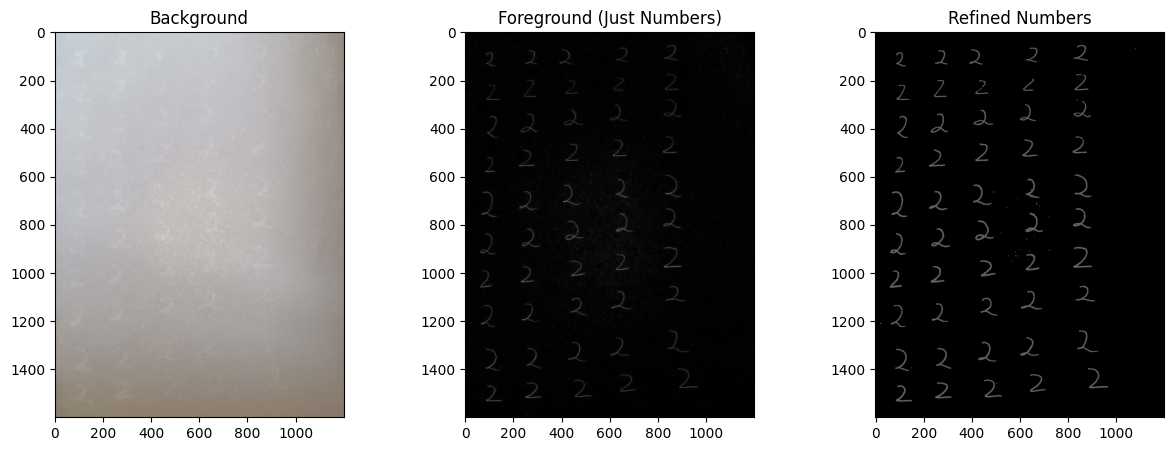

3120
3021
59
0
98


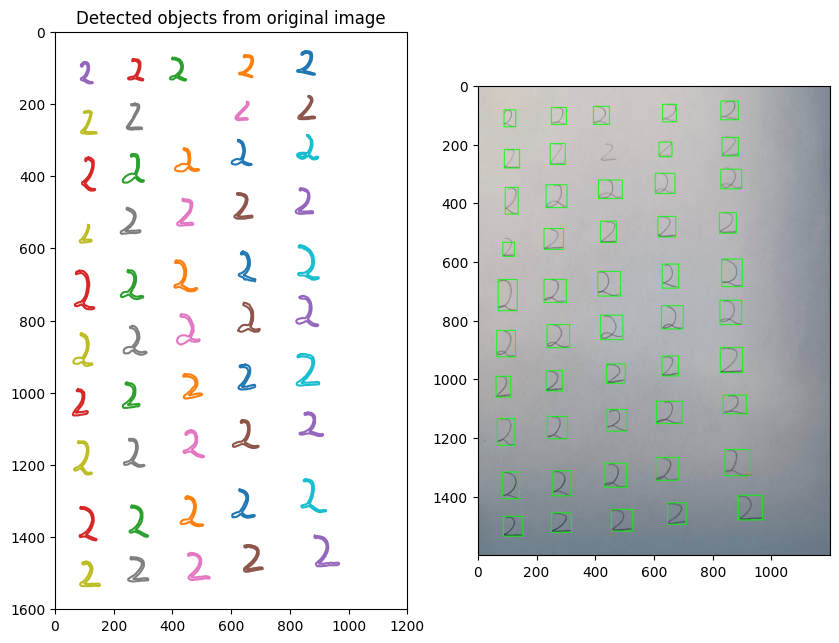

#########################################################################

EXTRACTION OF DIGIT 3

#########################################################################


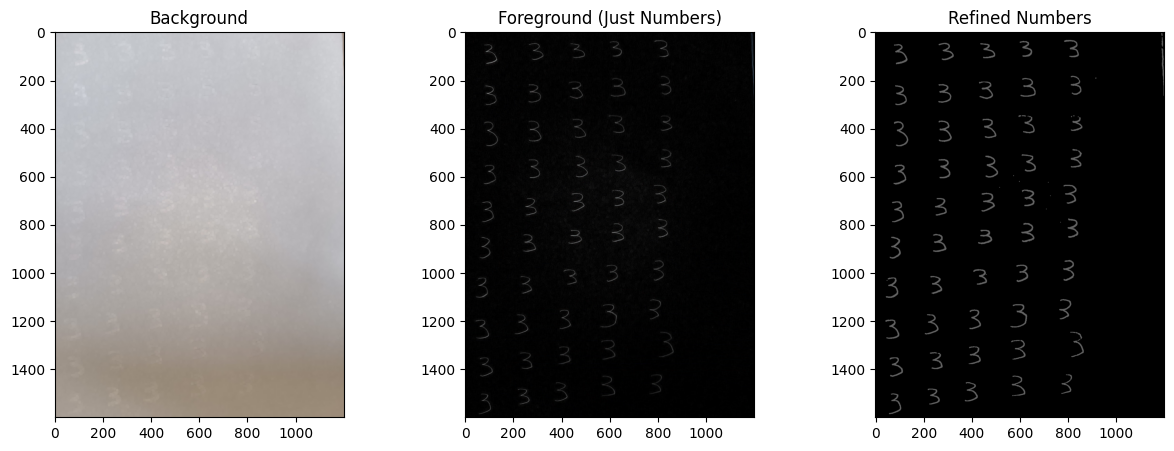

2905
2823
62
0
81


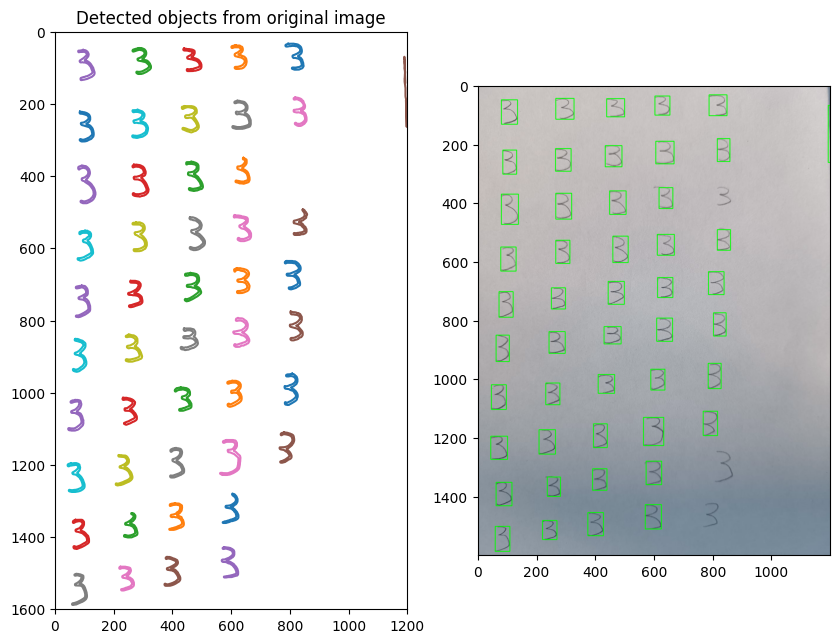

#########################################################################

EXTRACTION OF DIGIT 4

#########################################################################


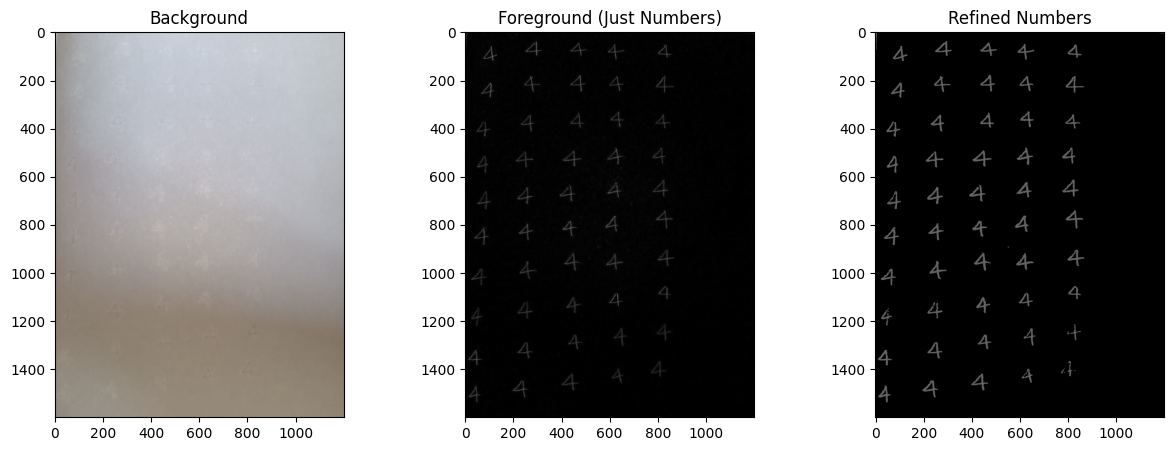

2917
2788
74
0
128


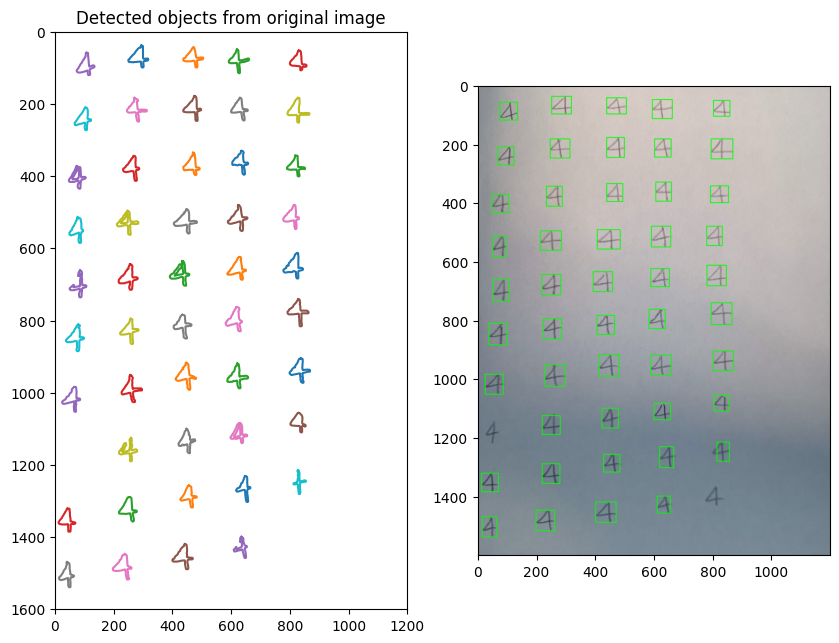

#########################################################################

EXTRACTION OF DIGIT 5

#########################################################################


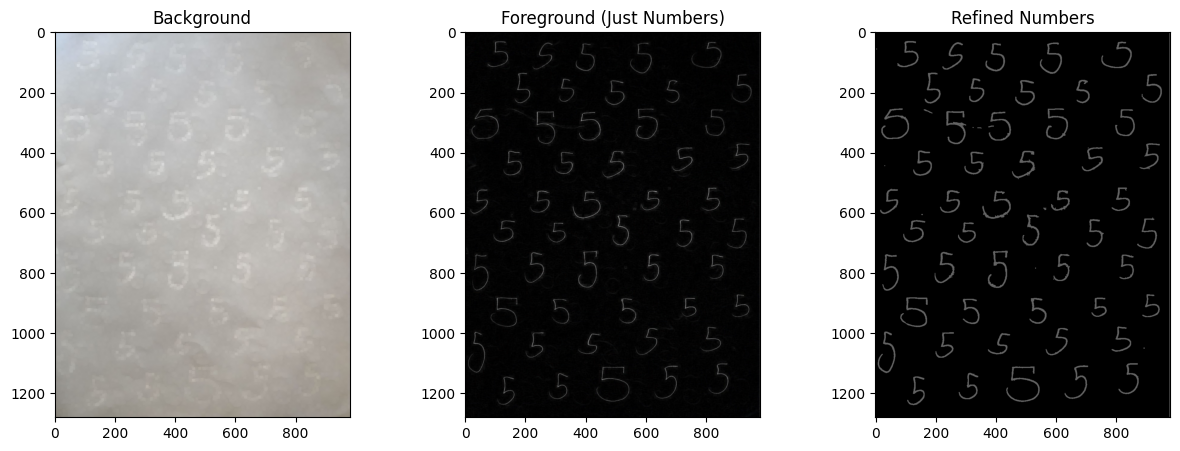

3237
3162
156
0
74


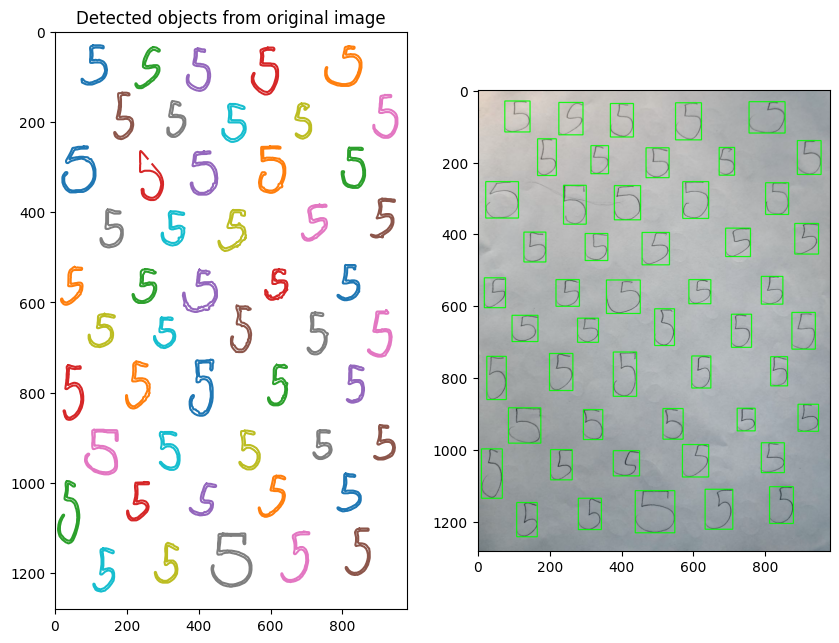

#########################################################################

EXTRACTION OF DIGIT 6

#########################################################################


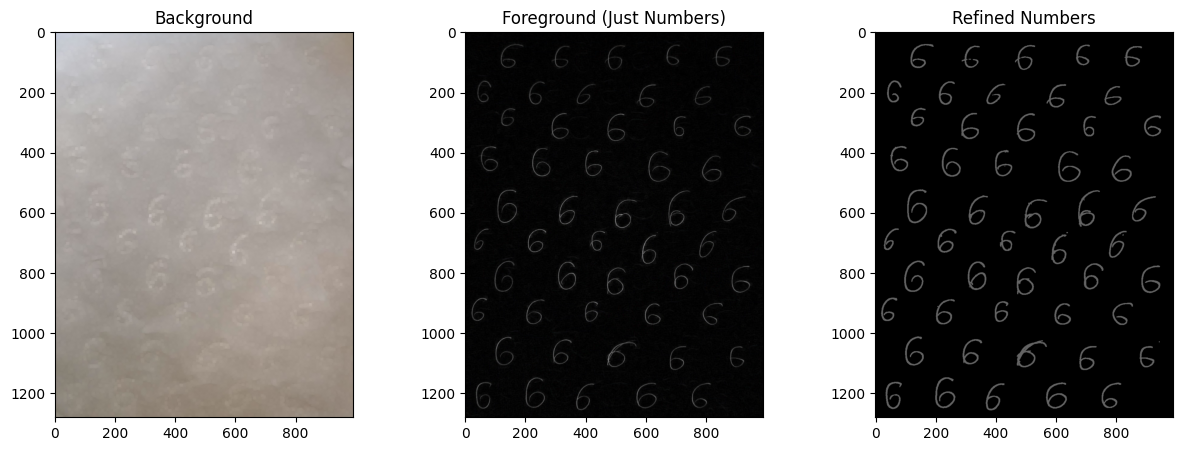

4957
4859
115
0
97


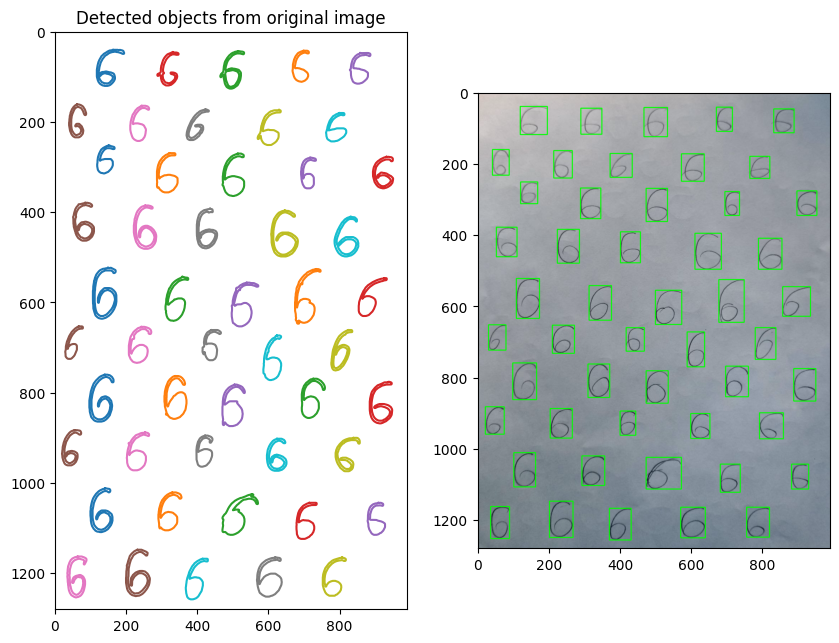

#########################################################################

EXTRACTION OF DIGIT 7

#########################################################################


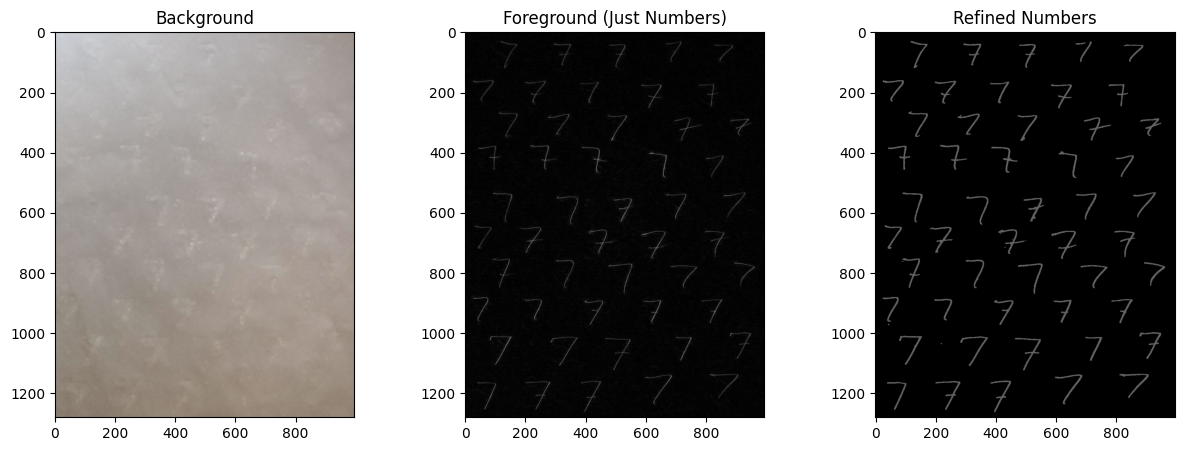

4127
4064
82
0
62


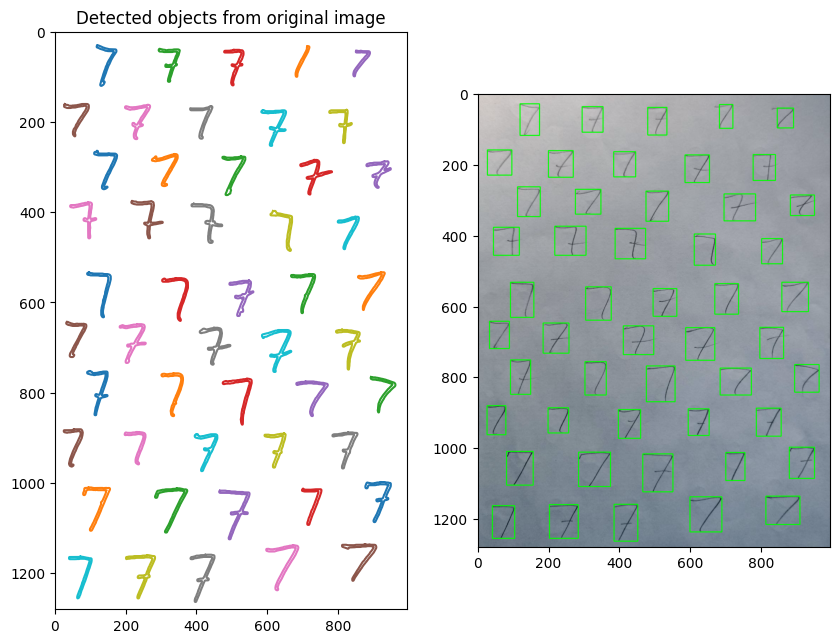

#########################################################################

EXTRACTION OF DIGIT 8

#########################################################################


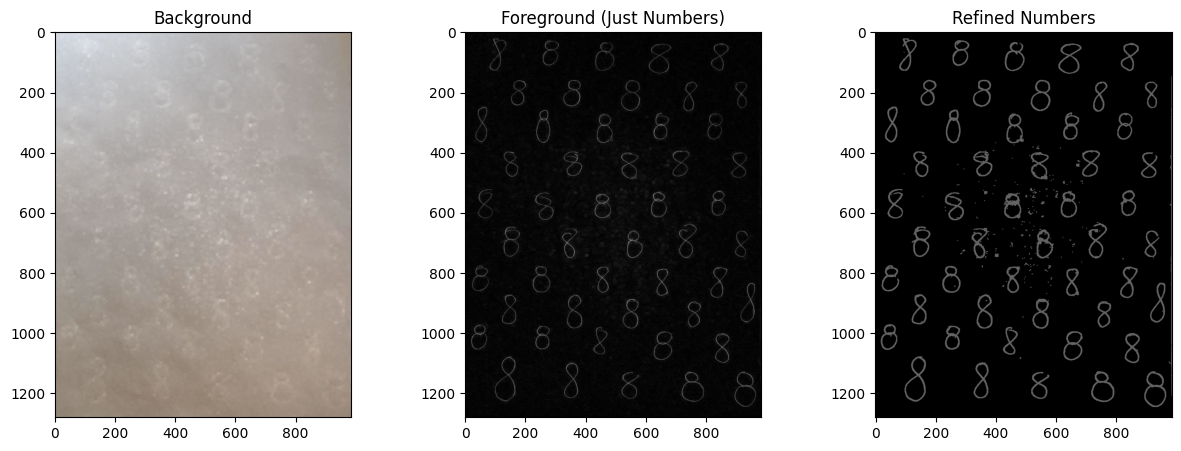

5635
5293
81
0
341


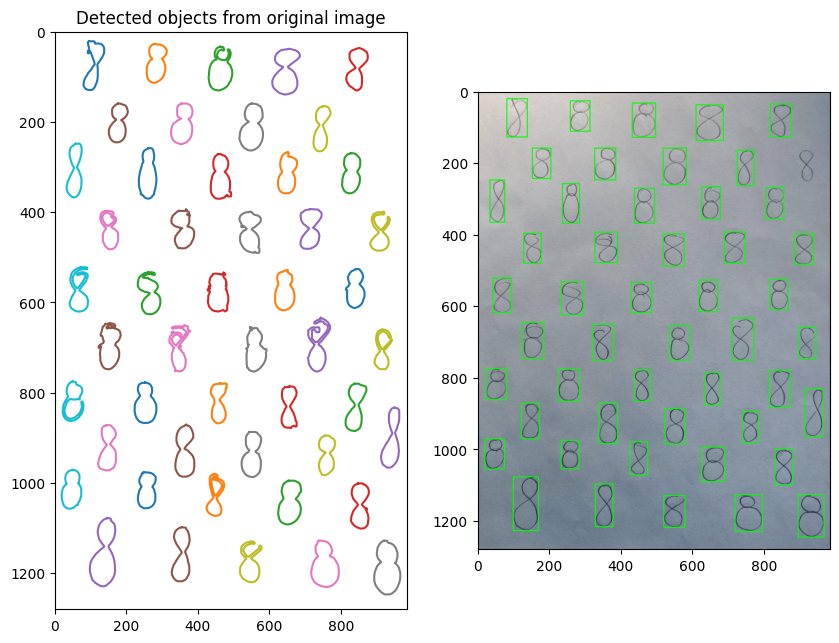

#########################################################################

EXTRACTION OF DIGIT 9

#########################################################################


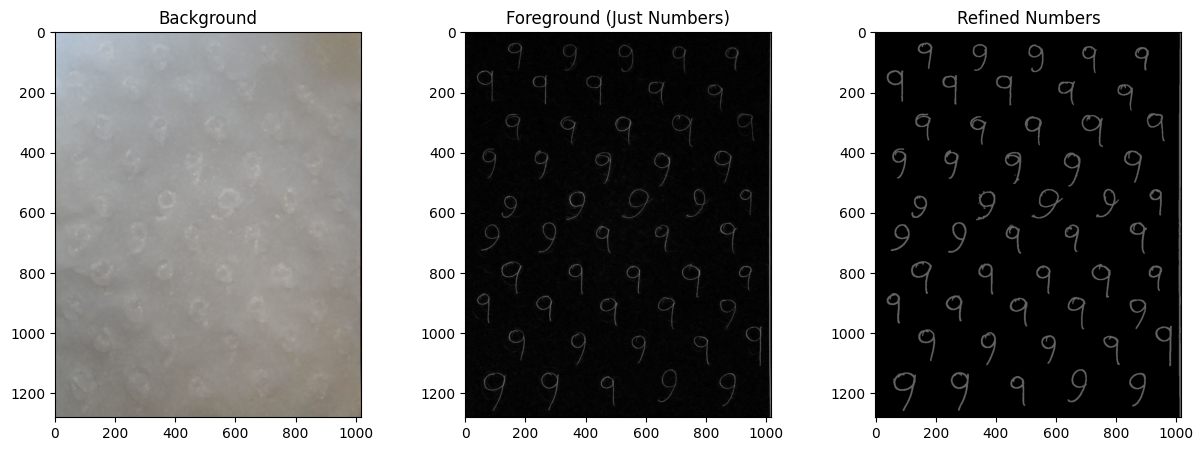

3983
3829
116
0
153


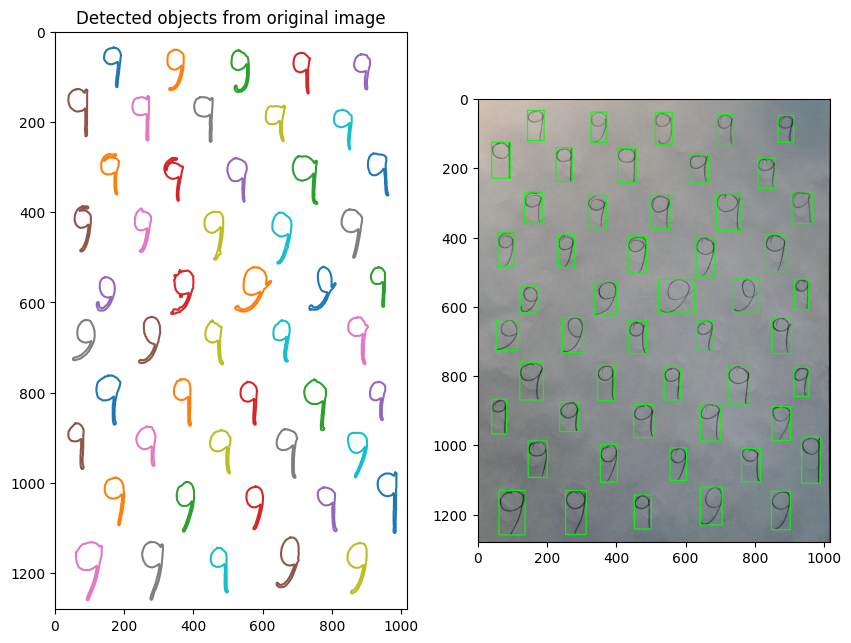

In [416]:
# Definition of a perimeter sensitivity to avoid getting features for useless regions
PERIMETERS = [
    (300, 700), # 0
    (100, 700),
    (150, 700), # 2
    (250, 500),
    (200, 700), # 4
    (200, 1000),
    (200, 700), # 6
    (150, 700),
    (400, 700), # 8
    (200, 700)
    ]

featuresfile = open(f"trainingDataset_AllDigits.csv", "w",newline="")
writer = csv.writer(featuresfile)
colnames=["Digit", "euler", "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"]
writer.writerow(colnames)

for digit in range(0, 10):

    print("#########################################################################")
    print()
    print(f"EXTRACTION OF DIGIT {digit}")
    print()
    print("#########################################################################")

    frame = cv.imread(os.path.join("digits", f"{digit}.jpeg"))
    rawImg = frame.copy()

    kernel = np.ones((5,5),np.uint8)
    bkgnd = cv.dilate(frame,kernel,iterations = 1)
    bkgnd = cv.dilate(bkgnd,kernel,iterations = 1)

    frame = (bkgnd - frame)
    frgnd = frame.copy()
    
    kernel = np.ones((3,3),np.uint8)
    frame = cv.dilate(frame,kernel,iterations = 1)
    
    green = frame[:,:,2]
    ret,img = cv.threshold(green, 32, 100, 0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv.cvtColor(bkgnd, cv.COLOR_BGR2RGB))
    ax[0].set_title("Background")
    
    ax[1].imshow(cv.cvtColor(frgnd, cv.COLOR_BGR2RGB))
    ax[1].set_title("Foreground (Just Numbers)")
    
    ax[2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax[2].set_title("Refined Numbers")
    plt.show()
    
    # ###################
    labeled, regions, EdgeImage = SegmentationRegions(img,frame)

    labeled = labeled % 21

    img = cv.normalize(labeled, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    im_color = cv.applyColorMap(img, cv.COLORMAP_HSV)
    im_color = cv.medianBlur(im_color,3)
    RGB_im = cv.cvtColor(im_color, cv.COLOR_BGR2RGB)

    # ###################

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    boundaries = []
    for n in range(len(regions)-2):
        idx = n+2
        if regions[idx].Perimetro > PERIMETERS[digit][0]:
            if regions[idx].Perimetro < PERIMETERS[digit][1]:

                pointlist = orderPointSet(regions[idx].edgePoints, EdgeImage)
                smoothpoints = np.array(smoothPointSet(pointlist[0],3))
                euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7, xMin, yMin, xMax, yMax = getInvariantFeatures(pointlist, displayIndividual=False)
                rowfeature = [int(digit), euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7]
                writer.writerow(rowfeature)

                boundaries.append(((xMin, yMin), (xMax, yMax)))

                ax[0].plot(smoothpoints[:,0],smoothpoints[:,1])

    ax[0].set_ylim(frame.shape[0], 0)
    ax[0].set_xlim(0, frame.shape[1])
    ax[0].set_title("Extracted Regions")

    boundedImg = rawImg.copy()
    for startPoint, endPoint in boundaries:
        cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
    ax[1].imshow(boundedImg)
    ax[1].set_title("Detected objects from original image")

    plt.show()

featuresfile.close()

<hr />

## Model Training

In this section, based on the created CSV file with approximately 50 samples per digit, we train 3 different classifiers: 

* Support Vector Classifier (SVC)
* Decision Trees (DT)
* Random Forest (RF)

We use out Student ID as test sets to assess the quality of recognition using this simpler approach.

In [418]:
df = pd.read_csv("trainingDataset_AllDigits.csv")
df

Digit  euler       Hu1        Hu2        Hu3       Hu4        Hu5  \
0        0      1  5.384709   1.489993   5.909982  0.759683  -0.554882   
1        0      1  6.474037   5.442867   0.530058  0.013285   0.000879   
2        0      1  3.107118   1.435844   0.450297  0.047508   0.002103   
3        0      1  5.802750   1.481768   0.525297  0.012451  -0.000710   
4        0      1  5.633965   3.978982   0.280501  0.020723   0.001183   
..     ...    ...       ...        ...        ...       ...        ...   
488      9      1  5.136887  10.746555  10.808438  2.923951   8.201701   
489      9      1  5.249713   6.847667  28.600078  1.383320   1.851842   
490      9      1  5.162316  11.233403  26.504664  2.082517 -15.215564   
491      9      1  4.708165   8.068559  10.216617  1.514683  -1.135186   
492      9      1  4.098544   8.365897  11.077894  0.556120  -0.610414   

          Hu6        Hu7  
0    0.881351  -1.511026  
1    0.030994   0.000685  
2    0.056756   0.006623  
3    0.002768   0.000714  
4    0.041180   0.001047  
..        ...        ...  
488 -3.800582  14.245162  
489 -3.518296   8.501622  
490 -4.441049  -2.804761  
491 -4.166123   5.849352  
492 -1.608316   1.238018  

[493 rows x 9 columns]

Simple dimensionality reduction visualization to get a glimpse into the separation of classes (digits), as there are some that could be easily confused (like 1 and 7).

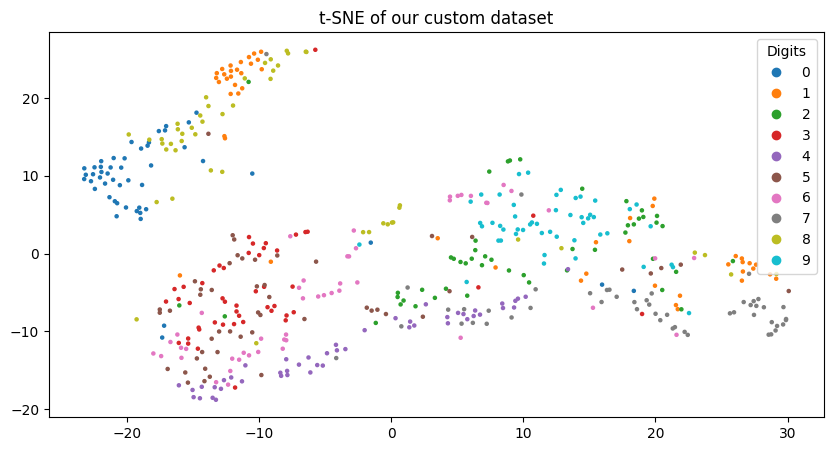

In [432]:
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(df.drop(columns=["Digit"]))

plt.figure(figsize=(10, 5))
scatter = plt.scatter(projections[:, 0], projections[:, 1], c=df["Digit"].astype(int), cmap="tab10", s=5)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of our custom dataset")
plt.show()

array([1, 5, 2, 7])